# Training

## Importing Files

In [1]:
from torch.utils.data import DataLoader
import gc
import torch
from tqdm.notebook import tqdm
import math

from fasterrcnn.config import config
from augmentations.aug import get_augmentor
from fasterrcnn.utils.data import WheatDataset, collate_fn
from fasterrcnn.utils.training_handler import get_training_handler

## Data and Training Configuration Params

In [2]:
new_training = True

In [3]:
conf = config()
augmentor = get_augmentor()
handler = get_training_handler(conf, new=new_training, starter_dir={'date': '0623', 'version':'01'})


WD = WheatDataset(conf, 
                  is_train=True, 
                  augmentation=True,
                  normalize=False,
                  augmentor=augmentor, 
                  random_seed=0)
WD_Train_Loader = DataLoader(WD, 
                             batch_size=conf.BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=collate_fn)


model = handler.get_fasterrcnn()
_ = model.train()
_ = model.to(conf.DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(params, lr=0.0007,momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.AdamW(params, lr=0.0007, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95, last_epoch=-1)

if not new_training:
    optimizer_states, scheduler_states = handler.load_optimizers_and_scheduler()
    optimizer.load_state_dict(optimizer_states)
    scheduler.load_state_dict(scheduler_states)

## Training 

In [ ]:
end_epochs=3

epoch_progress_bar = tqdm(range(handler.last_epoch, end_epochs))
for epoch in epoch_progress_bar:
    _epoch_loss=0
    data_progress_bar = tqdm(WD_Train_Loader)
    for images, targets in data_progress_bar:
        
        #try:
        images = [torch.tensor(image, dtype = torch.float32).to(conf.DEVICE) for image in images]
        targets = [{k: torch.tensor(v).to(conf.DEVICE) for k, v in target.items()} for target in targets]

        loss_dir = model(images,targets)
        summed_loss = sum(loss for loss in loss_dir.values())
        summed_loss_value = summed_loss.item()

        if math.isfinite(summed_loss_value):
            optimizer.zero_grad()
            summed_loss.backward()
            optimizer.step()
            _epoch_loss+=summed_loss_value

        else:
            print('Loss is undefined:',summed_loss_value,'   skipping BackProp for step no:',_iter)
            print(loss_dictionary)

        handler.publish_to_board(total_loss=summed_loss_value, 
                                 classifier_loss=loss_dir['loss_classifier'].item(), 
                                 reg_box_loss=loss_dir['loss_box_reg'].item(), 
                                 objectness_loss=loss_dir['loss_objectness'].item(), 
                                 rpn_reg_loss=loss_dir['loss_rpn_box_reg'].item())
            

            
            
    handler.save_weights(model, 0, _epoch_loss, optimizer, scheduler, new_epoch=True)
    scheduler.step()
    torch.cuda.empty_cache()
    gc.collect()    

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)



weights_saved...



weights_saved...


# Inference

In [1]:
from torch.utils.data import DataLoader
import gc
import torch
from tqdm.notebook import tqdm


from fasterrcnn.config import config
from fasterrcnn.utils.inferencefns import (WheatInferenceDataset, 
                                           collate_fn, 
                                           format_prediction_string, 
                                           make_submission_file)
from fasterrcnn.model import get_model

In [2]:
conf = config()
WD_Inference = WheatInferenceDataset(conf, normalize=False)
WD_Inference_Loader = DataLoader(WD_Inference,
                                 batch_size=conf.BATCH_SIZE, 
                                 shuffle=False, 
                                 collate_fn=collate_fn)

model = get_model(saved_weights='saved_weights/fasterrcnn/GWD_FASTERRCNN_0622V02_EPOCH_3_CHECKPOINT_0_SCORE_0.0000_LOSS_245.2947.pth')

_ = model.eval()
_ = model.to(conf.DEVICE)

In [4]:
cut_off = 0.45
pred_strings = []
image_ids = []
for ids, imgs in WD_Inference_Loader:
    imgs = [torch.tensor(img, dtype = torch.float32).to(conf.DEVICE) for img in imgs]
    results = model(imgs)
    results = [{k: v.to(torch.device('cpu')).detach().numpy() for k, v in result.items()} for result in results]
    
    for result, id_ in zip(results, ids) :
        scores = result['scores']
        try:
            stop_index = np.argwhere(scores<cut_off)[0][0]
        except:
            stop_index=len(result['scores'])
        pred_string = format_prediction_string(result['boxes'][:stop_index], result['scores'][:stop_index])
        pred_strings.append(pred_string)
        image_ids.append(id_)

make_submission_file(image_ids, pred_strings)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


file_saved


In [6]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    return img


def visualize(annotations):
    img = annotations['img'].copy()
    for idx, bbox in enumerate(annotations['boxes']):
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


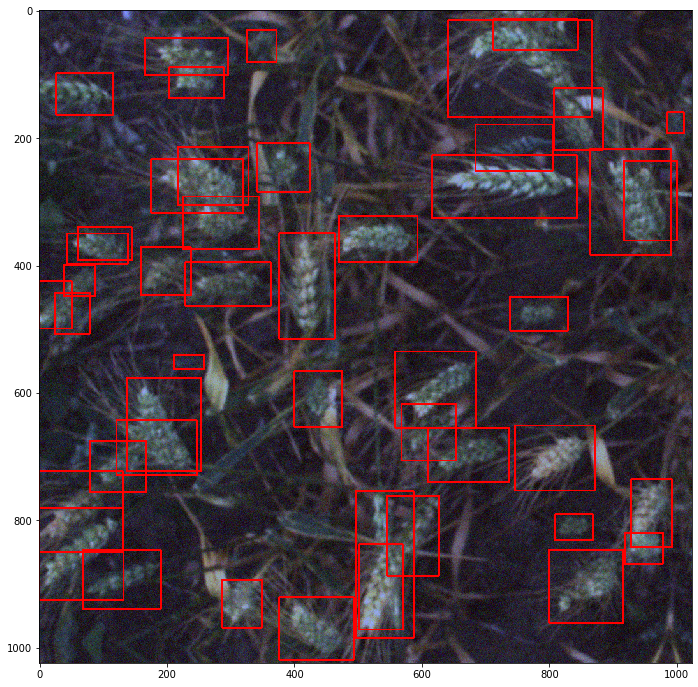

In [7]:
visualize({'img': img, 'boxes': data[1]['boxes']})

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

from fasterrcnn.utils.data import WheatDataset
from fasterrcnn.config import config
from fasterrcnn.model import get_model
from augmentations.aug import get_augmentor

In [2]:
augg = get_augmentor()

In [3]:
conf = config()
WD = WheatDataset(config, is_train=True, augmentation=True, augmentor=augg, random_seed=0)
data = WD[0]
data

(array([[[-2.090675  , -1.946819  , -1.7070588 , ...,  1.8573759 ,
           1.6815517 ,  1.4577755 ],
         [-2.090675  , -2.010755  , -1.7390269 , ...,  1.7454877 ,
           1.6016316 ,  1.4417915 ],
         [-2.154611  , -2.0427232 , -1.818947  , ...,  1.5696636 ,
           1.5536796 ,  1.5057275 ],
         ...,
         [ 0.69054294,  0.8503831 ,  1.0102232 , ...,  1.985248  ,
           2.177056  ,  2.2090242 ],
         [-0.25251374, -0.07668961,  0.14708656, ...,  1.0262072 ,
           1.2020314 ,  1.2819514 ],
         [-0.79597014, -0.6840821 , -0.540226  , ...,  0.6106229 ,
           0.722511  ,  0.8663671 ]],
 
        [[-2.393105  , -2.2205243 , -1.9328897 , ...,  2.7843192 ,
           2.4966843 ,  2.2282252 ],
         [-2.450632  , -2.297227  , -2.0287678 , ...,  2.630914  ,
           2.4391575 ,  2.247401  ],
         [-2.5465102 , -2.393105  , -2.1438217 , ...,  2.458333  ,
           2.4391575 ,  2.3816304 ],
         ...,
         [ 0.8859302 ,  1.0776867